In [2]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import shapefile
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models
#import models.simple_depth_morph_models as simple_models
# import models.shallow_depth_morph_models_org as sdmodels

import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

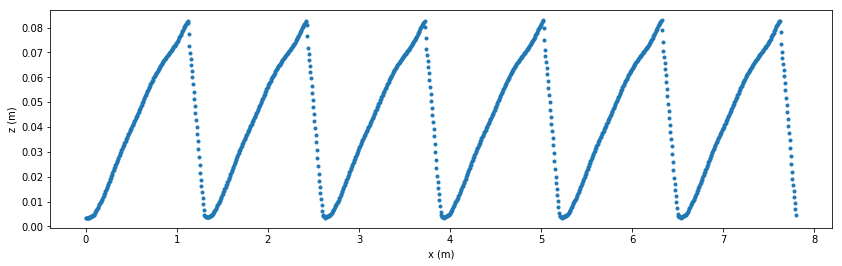

In [3]:
filepath = '../Paper_3/dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [7]:
vertsArray = {}

run_name = 'Section_5.3.dune_5_TvdWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['TVD-Weno'] = verts

run_name = 'Section_5.3.dune_5_EulerWeno_q_32m_h_357mm_D50_1.0mm_25ms_verts.npy_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Euler-Weno'] = verts

run_name = 'Section_5.3.dune_5_MacCormack_q_32m_h_357mm_D50_1.0mm_mr_153_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['MacCormack_153ms'] = verts

run_name = 'Section_5.3.dune_5_upwind_q_32m_h_357mm_D50_1.0mm_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Upwind'] = verts

In [6]:
dt = 5

for key, verts in vertsArray.items():
    w = shapefile.Writer('_S52_output/{0}_32.shp'.format(key), shapeType=shapefile.POLYLINE)
    w.field('Time','C',40)
    
    i=0

    for t in verts[:,0,0]:
        
        XY = list(zip(verts[i,:,0], (100*verts[i,:,1] + i*dt + 5)))
        coordlist = [[float(coord) for coord in pair] for pair in XY]
        
        cord = []
        cord.append(coordlist)
        w.line(cord)
        w.record('{0}'.format(i*dt))

        i+=1
        print(key, i)
    w.close()



MacCormack_153ms 1
MacCormack_153ms 2
MacCormack_153ms 3
MacCormack_153ms 4
MacCormack_153ms 5
MacCormack_153ms 6
MacCormack_153ms 7
MacCormack_153ms 8
MacCormack_153ms 9
MacCormack_153ms 10
MacCormack_153ms 11
MacCormack_153ms 12
MacCormack_153ms 13
MacCormack_153ms 14
MacCormack_153ms 15
MacCormack_153ms 16
MacCormack_153ms 17
MacCormack_153ms 18
MacCormack_153ms 19
MacCormack_153ms 20
MacCormack_153ms 21
MacCormack_153ms 22
MacCormack_153ms 23
MacCormack_153ms 24
MacCormack_153ms 25
MacCormack_153ms 26
MacCormack_153ms 27
MacCormack_153ms 28
MacCormack_153ms 29
MacCormack_153ms 30
MacCormack_153ms 31
MacCormack_153ms 32
MacCormack_153ms 33
MacCormack_153ms 34
MacCormack_153ms 35
MacCormack_153ms 36
MacCormack_153ms 37
MacCormack_153ms 38
MacCormack_153ms 39
MacCormack_153ms 40
MacCormack_153ms 41
MacCormack_153ms 42
MacCormack_153ms 43
MacCormack_153ms 44
MacCormack_153ms 45
MacCormack_153ms 46
MacCormack_153ms 47
MacCormack_153ms 48
MacCormack_153ms 49
MacCormack_153ms 50
MacCormac

In [7]:
i

0

In [27]:
vertsArray = {}

run_name = 'Section_5.2_dune_5_TVDWeno_q_20cm_h_237mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['TVD-Weno'] = verts

run_name = 'Section_5.2_dune_5_EulerWenoModel_q_20cm_h_237mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Euler-Weno'] = verts

run_name = 'Section_5.2_dune_5_MacCormack_q_20cm_h_237mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['MacCormack'] = verts

run_name = 'Section_5.2_dune_5_MacCormack_q_32m_h_357mm_D50_smooth_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['MacCormack-Smooth'] = verts

run_name = 'Section_5.2_dune_5_Upwind_q_20cm_h_237mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))
vertsArray['Upwind'] = verts


In [28]:
dt = 5

for key, verts in vertsArray.items():
    w = shapefile.Writer('_S52_output/{0}_20.shp'.format(key), shapeType=shapefile.POLYLINE)
    w.field('Time','C',40)
    
    i=0

    for t in verts[:,0,0]:
        
        XY = list(zip(verts[i,:,0], (100*verts[i,:,1] + i*dt + 5)))
        coordlist = [[float(coord) for coord in pair] for pair in XY]
        
        cord = []
        cord.append(coordlist)
        w.line(cord)
        w.record('{0}'.format(i*dt))

        i+=1
        print(key, i)
    w.close()


TVD-Weno 1
TVD-Weno 2
TVD-Weno 3
TVD-Weno 4
TVD-Weno 5
TVD-Weno 6
TVD-Weno 7
TVD-Weno 8
TVD-Weno 9
TVD-Weno 10
TVD-Weno 11
TVD-Weno 12
TVD-Weno 13
TVD-Weno 14
TVD-Weno 15
TVD-Weno 16
TVD-Weno 17
TVD-Weno 18
TVD-Weno 19
TVD-Weno 20
TVD-Weno 21
TVD-Weno 22
TVD-Weno 23
TVD-Weno 24
TVD-Weno 25
TVD-Weno 26
TVD-Weno 27
TVD-Weno 28
TVD-Weno 29
TVD-Weno 30
TVD-Weno 31
TVD-Weno 32
TVD-Weno 33
TVD-Weno 34
TVD-Weno 35
TVD-Weno 36
TVD-Weno 37
TVD-Weno 38
TVD-Weno 39
TVD-Weno 40
TVD-Weno 41
TVD-Weno 42
TVD-Weno 43
TVD-Weno 44
TVD-Weno 45
TVD-Weno 46
TVD-Weno 47
TVD-Weno 48
TVD-Weno 49
TVD-Weno 50
TVD-Weno 51
TVD-Weno 52
TVD-Weno 53
TVD-Weno 54
TVD-Weno 55
TVD-Weno 56
TVD-Weno 57
TVD-Weno 58
TVD-Weno 59
Euler-Weno 1
Euler-Weno 2
Euler-Weno 3
Euler-Weno 4
Euler-Weno 5
Euler-Weno 6
Euler-Weno 7
Euler-Weno 8
Euler-Weno 9
Euler-Weno 10


Exception ignored in: <bound method Writer.__del__ of <shapefile.Writer object at 0x7f246fe0bdd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/pyshp-2.1.0-py3.6.egg/shapefile.py", line 1104, in __del__
    self.close()
  File "/usr/local/lib/python3.6/site-packages/pyshp-2.1.0-py3.6.egg/shapefile.py", line 1122, in close
    "with the number of shapes (%s)" % (self.recNum, self.shpNum))
shapefile.ShapefileException: When saving both the dbf and shp file, the number of records (0) must correspond with the number of shapes (1)


Euler-Weno 11
Euler-Weno 12
Euler-Weno 13
Euler-Weno 14
Euler-Weno 15
Euler-Weno 16
Euler-Weno 17
Euler-Weno 18
Euler-Weno 19
Euler-Weno 20
Euler-Weno 21
Euler-Weno 22
Euler-Weno 23
Euler-Weno 24
Euler-Weno 25
Euler-Weno 26
Euler-Weno 27
Euler-Weno 28
Euler-Weno 29
Euler-Weno 30
Euler-Weno 31
Euler-Weno 32
Euler-Weno 33
Euler-Weno 34
Euler-Weno 35
Euler-Weno 36
Euler-Weno 37
Euler-Weno 38
Euler-Weno 39
Euler-Weno 40
Euler-Weno 41
Euler-Weno 42
Euler-Weno 43
Euler-Weno 44
Euler-Weno 45
Euler-Weno 46
Euler-Weno 47
Euler-Weno 48
Euler-Weno 49
Euler-Weno 50
Euler-Weno 51
Euler-Weno 52
Euler-Weno 53
Euler-Weno 54
Euler-Weno 55
Euler-Weno 56
Euler-Weno 57
Euler-Weno 58
Euler-Weno 59
MacCormack 1
MacCormack 2
MacCormack 3
MacCormack 4
MacCormack 5
MacCormack 6
MacCormack 7
MacCormack 8
MacCormack 9
MacCormack 10
MacCormack 11
MacCormack 12
MacCormack 13
MacCormack 14
MacCormack 15
MacCormack 16
MacCormack 17
MacCormack 18
MacCormack 19
MacCormack 20
MacCormack 21
MacCormack 22
MacCormack 23
M

In [1]:
#https://gis.stackexchange.com/questions/85448/creating-polygon-shapefile-from-list-of-x-y-coordinates-using-python
import shapefile

In [66]:
import shapefile

ModuleNotFoundError: No module named 'shapefile'

In [33]:

run_name = 'Section_5.2_dune_5_Upwind_q_20cm_h_237mm_D50_0.001_verts.npy'
verts = np.load('_output/{0}'.format(run_name))



Text(0.5, 0, 'x (m)')

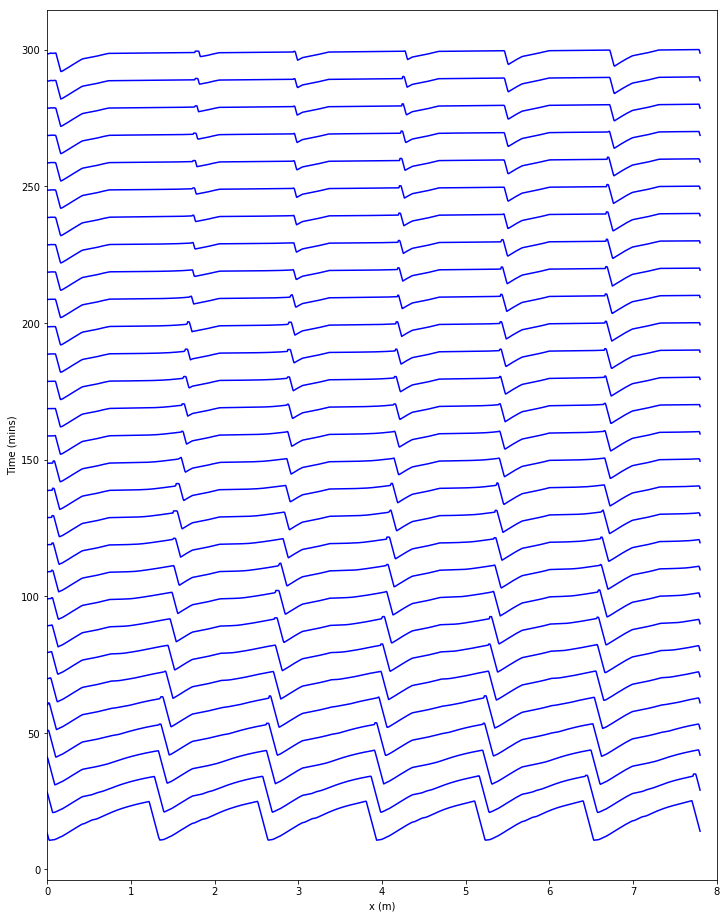

In [34]:
fig, ax = plt.subplots(figsize=(12, 16))
ax.set_xlim(0,8)
dt=5
i=0
insert = False
for t in verts[:,0,0]:
    if insert == True:
        plt.plot(verts[i,:,0], (200*verts[i,:,1] + i*dt + 5),color='b')
        insert = False
    else:
        insert = True
    i+=1
ax.set_ylabel('Time (mins)')
ax.set_xlabel('x (m)')

In [60]:
run_name = 'Section_5.2_dune_5_q_20cm_h_237mm_D50_0.001_verts.npy'
run_name = 'Section_5.2_dune_5_Upwind_q_20cm_h_237mm_D50_0.001_verts.npy'
run_name = 'Section_5.2_dune_5_MacCormack_q_20cm_h_237mm_D50_0.001_verts.npy'
run_name = 'Section_5.2_dune_5_EulerWenoModel_q_20cm_h_237mm_D50_0.001_verts.npy'

5_mins_x
5_mins_z
10_mins_x
10_mins_z
15_mins_x
15_mins_z
20_mins_x
20_mins_z
25_mins_x
25_mins_z
30_mins_x
30_mins_z
35_mins_x
35_mins_z
40_mins_x
40_mins_z
45_mins_x
45_mins_z
50_mins_x
50_mins_z
55_mins_x
55_mins_z
60_mins_x
60_mins_z
65_mins_x
65_mins_z
70_mins_x
70_mins_z
75_mins_x
75_mins_z
80_mins_x
80_mins_z
85_mins_x
85_mins_z
90_mins_x
90_mins_z
95_mins_x
95_mins_z
100_mins_x
100_mins_z
105_mins_x
105_mins_z
110_mins_x
110_mins_z
115_mins_x
115_mins_z
120_mins_x
120_mins_z
125_mins_x
125_mins_z
130_mins_x
130_mins_z
135_mins_x
135_mins_z
140_mins_x
140_mins_z
145_mins_x
145_mins_z
150_mins_x
150_mins_z
155_mins_x
155_mins_z
160_mins_x
160_mins_z
165_mins_x
165_mins_z
170_mins_x
170_mins_z
175_mins_x
175_mins_z
180_mins_x
180_mins_z
185_mins_x
185_mins_z
190_mins_x
190_mins_z
195_mins_x
195_mins_z
200_mins_x
200_mins_z
205_mins_x
205_mins_z
210_mins_x
210_mins_z
215_mins_x
215_mins_z
220_mins_x
220_mins_z
225_mins_x
225_mins_z
230_mins_x
230_mins_z
235_mins_x
235_mins_z
240_mi